In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
import itertools
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
HS300 = list(ts.get_hs300s()['code'])

BENCHMARK = '399300'
# TARGET = ['399300']
TARGET = HS300
# BENCHMARK = 'NDX'
# TARGET = NASDAQ100
# BENCHMARK = 'BITCOIN'
# TARGET = CRYPTOCURRENCY
# BENCHMARK = 'EOS'
# TARGET = ['EOS']

ALL_TARGET = TARGET[:]

pd

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False
spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()
timeframe = '10y'
ignore = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break

    # 沪深300指数
    if symbol == '399300':
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # NASDAQ
    elif symbol in NASDAQ100:
        datafile = None
        while datafile is None:
            try:
                datafile = spider_n.get_stock_data(symbol, timeframe)
            except:
                time.sleep(5)
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2005-01-01'
end_date = '2018-08-01'

TURTLE_POS = 50
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = True
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

def get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    stock_df_dict = {}
    for symbol in TARGET + [BENCHMARK]:
        stock_data_file = '../database/market/%s.csv' % symbol
        stock_df = pd.read_csv(stock_data_file)

        # 筛选字段
        stock_df = stock_df.loc[:, ['date', 'open', 'close']]

        # 去掉Nasdaq行情首行的当天行情
        if symbol in NASDAQ100:
            stock_df = stock_df.drop([0])

        # 抛弃空值异常值
        stock_df.dropna(axis=0, how='any', inplace=True)

        # 格式化日期
        stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

        # 用日期作索引，日期升序排序
        if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
            stock_df = stock_df[::-1]
        stock_df.set_index(['date'], inplace=True)
        stock_df.index = stock_df.index.to_period('D')

        # 计算每天涨跌幅
        stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
        stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)

        # Turtle指标
        stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
        stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
        stock_df['MA180'] = stock_df['open'].rolling(180).mean()
        stock_df['MA60'] = stock_df['open'].rolling(60).mean()
        stock_df['MA30'] = stock_df['open'].rolling(30).mean()

        # 减少数据
        stock_df.dropna(how='any', inplace=True)

        stock_df_dict[symbol] = stock_df
        
    return stock_df_dict

Wall time: 0 ns


In [5]:
%%time
# %xmode

def run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    PROPERTY = START_MONEY
    CASH = START_MONEY
    count_day = 0
    yesterday = None
    miss_buy_short = 0
    miss_buy_long = 0
    
    '''用基准数据来存储策略数据'''
    show_df = None
    show_df = stock_df_dict[BENCHMARK].copy()
    show_df.loc[:, 'CASH_TURTLE'] = START_MONEY
    show_df.loc[:, 'PROPERTY_TURTLE'] = START_MONEY

    order_df = None
    order_df = pd.DataFrame(columns=[
        'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
    ])

    ops_df = None
    ops_df = pd.DataFrame(columns=[
        'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
    ])


    # 时间序列
    for today in pd.period_range(start=start_date, end=end_date, freq='D'):
        count_day += 1

        # 每年年初计算回报率
        if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
            print(today, time.ctime())
    #         if today.dayofyear == 1:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
    #         else:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
    #         lastyear_firstday = lastyear_firstday.to_period(freq='D')
    # #         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY_TURTLE)
    #         if today > show_df.iloc[0].name:
    #             today_property = show_df[:today].iloc[-2].PROPERTY_TURTLE
    # #             print(show_df[:today].iloc[-1])
    #         else:
    #             today_property = show_df.iloc[0].PROPERTY_TURTLE
    #         if lastyear_firstday > show_df.iloc[0].name:
    #             lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY_TURTLE
    #         else:
    #             lastyear_firstday_property = show_df.iloc[0].PROPERTY_TURTLE
    # #         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
    #         lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
    #         print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
        # 每年筛股
        if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
            TARGET = ALL_TARGET[:]
            benchmark_lastyear = stock_df_dict[BENCHMARK][:today]

            # 不到一年（250个交易日）
            if len(benchmark_lastyear) < 250:
                continue

            # 筛选过滤
            benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
            for symbol, stock_df in stock_df_dict.items():
                try:
                    return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                    if return_lastyear < benchmark_return_lastyear:
                        TARGET.remove(symbol)
    #                     print(symbol, return_lastyear)
                except:
                    TARGET.remove(symbol)
                    pass
            print(today, 'TARGET after filter', len(TARGET))


        if yesterday is None:
            yesterday = today
            continue

        # 日期不在基准交易日，则不交易
        if today not in stock_df_dict[BENCHMARK].index:
            continue

        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
                cur_order = order_df.loc[idx]
                symbol = cur_order['symbol']
                if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                    continue
                today_market = stock_df_dict[symbol].loc[today]
                if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
    #                 print(today, symbol, '跌停板，卖不掉')
                    continue
                if cur_order.buy_reason == 'SHORT':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if cur_order.buy_reason == 'LONG':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += cur_order.buy_count * today_market.open
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = today_market.open
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    #                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)

                    ops_df = ops_df.append(
                        {
                            'ops_date': today,
                            'ops': 'SELL',
                            'symbol': symbol,
                            'count': cur_order.buy_count,
                            'price': today_market.open,
                            'reason': cur_order.buy_reason,
                            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                        },
                        ignore_index=True
                    )

        # 开心止盈，倍数止盈
        if IS_HAPPYMONEY:        
            if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
                HAPPY_MONEY += START_MONEY
                PROPERTY -= START_MONEY
                CASH -= START_MONEY

        benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
        try:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
        except:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
        buy_list = []

        # 遍历标的，判断和执行买入
        for symbol in symbol_list:

            # 趋势交易，只在好行情时买入
            if IS_MARKETUP:
                if benchmark_today_market.MA60 < benchmark_today_market.MA180:
    #             if benchmark_yesterday_market.MA60 < benchmark_yesterday_market.MA180:
                    break

            # 是否购买基准
            if not IS_BUYBENCHMARK and symbol == BENCHMARK:
                continue

            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue

            # TIME TEST
            # DELETED

            today_market = stock_df_dict[symbol].loc[today]

            # 突破上行趋势，就买一份
            order_arr = order_df.to_records(index=False)
            is_buy = False
            # 指数就不要过滤器了
            if True:
                if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                    is_buy = True
                    buy_reason = 'LONG'
                elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                    is_buy = True
                    buy_reason = 'SHORT'

            if is_buy:
                buy_list.append(symbol)

        if IS_RANDOM_BUY:
            random.shuffle(buy_list)
        else:
            tmp_list = []
            for symbol in buy_list:
                try:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
                except:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
                tmp_list.append((return_lastyear, symbol))
            tmp_list = sorted(tmp_list, reverse=True)
            buy_list = [x[1] for x in tmp_list if x[0]>1]
    #         buy_list = [x[1] for x in tmp_list]

        for symbol in buy_list:
            today_market = stock_df_dict[symbol].loc[today]
            buy_count = 0

            # 滑点
            if IS_SLIPPAGE:
                buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
            else:
                buy_price = today_market.open

            # 按份数买
            if CASH >= PROPERTY / TURTLE_POS:
                buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

            # 指数购买，满仓干
    #         buy_count = int(CASH / buy_price)

            if buy_count > 0:
                if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
    #                 print(today, symbol, '涨停板，买不进')
                    continue

            if buy_count > 0:
                CASH -= buy_count * buy_price
    #             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                order_df = order_df.append(
                    {
                        'buy_date': today,
                        'symbol': symbol,
                        'buy_count': buy_count,
                        'buy_price': today_market.open,
                        'buy_reason': buy_reason,
                        'sell_date': pd.np.nan,
                        'sell_price': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'BUY',
                        'symbol': symbol,
                        'count': buy_count,
                        'price': buy_price,
                        'reason': buy_reason,
                        'profit': 0,
                    },
                    ignore_index=True
                )
            else:
                if buy_reason == 'LONG':
                    miss_buy_long += 1
                elif buy_reason == 'SHORT':
                    miss_buy_short += 1

        # 每天盘点财产
        # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
        if benchmark_today_market.MA60 < benchmark_today_market.MA180:
            CASH = CASH * (1 + 0.03 / 365)
        show_df.loc[today, 'CASH_TURTLE'] = CASH
        PROPERTY = CASH + \
            sum(
                [
                    stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                    for idx in order_df.loc[order_df['sell_price']==0].index
                ]
            )
        show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

        yesterday = today



    # 最后一天，清仓
    order_arr = order_df.to_records(index=False)
    for idx in order_df[order_df['sell_price'] == 0].index:
        cur_order = order_df.loc[idx]
        symbol = cur_order['symbol']
        today_market = stock_df_dict[symbol][:today].iloc[-1]
        CASH += cur_order.buy_count * today_market.open
        order_df.loc[idx, 'sell_date'] = today
        order_df.loc[idx, 'sell_price'] = today_market.open
        order_df.loc[idx, 'sell_reason'] = 'EXIT'
        order_df.loc[idx, 'profit'] = \
            (today_market.open - cur_order.buy_price) * cur_order.buy_count
        ops_df = ops_df.append(
            {
                'ops_date': today,
                'ops': 'SELL',
                'symbol': symbol,
                'count': cur_order.buy_count,
                'price': today_market.open,
                'reason': cur_order.buy_reason,
                'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
            },
            ignore_index=True
        )


#     print('START_MONEY', START_MONEY)
#     print('CASH', CASH)
#     print('HAPPY_MONEY', HAPPY_MONEY)
#     print('PROPERTY', PROPERTY)

#     s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
#     e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
#     print('BENCHMARK', s_p, e_p, e_p / s_p)
    return show_df, order_df, PROPERTY, miss_buy_long


Wall time: 0 ns


In [6]:
score_df = None
score_df = pd.DataFrame(columns=[
    'START',
    'END',
    'TURTLE_POS',
    'ROLLMAX',
    'ROLLMIN', 
    'MA_SHORT', 
    'MA_LONG', 
    'X_DAY_RETURN', 
    'ORDER',
    'STOCK',
    'RETURN',
    'MAXDROPDOWN',
    'WINRATE',
    'annual_return',
    'annual_volatility',
    'calmar_ratio',
    'sharpe_ratio',
    'alpha',
    'beta',
    'ALL_DAYS',
    'FREECASH_DAY',
    'MISS_SIGNAL',
    'RET_PER_YEAR',
])

In [79]:
TURTLE_POS = 40
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

# for i in range(6, 19, 1):
# for i in range(11, 14, 1):
for i in range(50, 71, 1):
    time.ctime()
    print(i)
#     global TURTLE_POS
#     TURTLE_POS = i * 5
    TURTLE_LONG_BUY_N = i
    TURTLE_LONG_SELL_N = i

    stock_df_dict = None
    show_df = None
    order_df = None
    PROPERTY = None
    symbol_list = TARGET + [BENCHMARK]

    stock_df_dict = get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
    show_df, order_df, PROPERTY, miss_buy_long = run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)

    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc[start_date:end_date]
    algo = df['PROPERTY_TURTLE'].pct_change()
    benchmark = df.open.pct_change()

#     if emp:
#         'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
#         'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
#         'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
#         'annual_volatility', emp.annual_volatility(algo, period='daily')
#         'calmar_ratio', emp.calmar_ratio(algo)
#         'sharpe_ratio', emp.sharpe_ratio(returns=algo)
#         'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
#         'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

    ALL_DAYS = len(df)
    FREECASH_DAY = len(df[df['CASH_TURTLE'] > (df['PROPERTY_TURTLE'] / TURTLE_POS)])


    output_str = ''
    for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0])+1, 1):
        y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y+1)]
        y_algo = y_df['PROPERTY_TURTLE'].pct_change()
        y_benchmark = y_df.open.pct_change()
        result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
            y, y+1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
        )
#         result
        output_str += result
        output_str += ';'
#     output_str

    df = order_df.copy()
    df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
    df = df.loc[:, ['symbol', 'pro_pct']]
    df = df.groupby(by='symbol').sum()
    buy_stock_count = len(df)
#     buy_stock_count
    
    score_df = score_df.append({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': TURTLE_LONG_BUY_N,
        'ROLLMIN': TURTLE_LONG_SELL_N, 
        'MA_SHORT': 60, 
        'MA_LONG': 180, 
        'X_DAY_RETURN': 250, 
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    }, ignore_index = True)

score_df
score_df.to_csv('../database/%s.csv' % time.strftime('%Y-%m-%d-%H-%M-%S'))

'Sun Sep  9 22:28:47 2018'

50
2005-01-01 Sun Sep  9 22:28:52 2018
2006-01-01 Sun Sep  9 22:28:52 2018
2007-01-01 Sun Sep  9 22:29:13 2018
2008-01-01 Sun Sep  9 22:29:36 2018
2009-01-01 Sun Sep  9 22:29:42 2018
2010-01-01 Sun Sep  9 22:30:06 2018
2011-01-01 Sun Sep  9 22:30:21 2018
2012-01-01 Sun Sep  9 22:30:39 2018
2013-01-01 Sun Sep  9 22:30:50 2018
2014-01-01 Sun Sep  9 22:31:18 2018
2015-01-01 Sun Sep  9 22:31:40 2018
2016-01-01 Sun Sep  9 22:32:20 2018
2017-01-01 Sun Sep  9 22:32:42 2018
2018-01-01 Sun Sep  9 22:33:50 2018
2018-08-01 Sun Sep  9 22:34:14 2018


'Sun Sep  9 22:34:14 2018'

51
2005-01-01 Sun Sep  9 22:34:19 2018
2006-01-01 Sun Sep  9 22:34:19 2018
2007-01-01 Sun Sep  9 22:34:40 2018
2008-01-01 Sun Sep  9 22:35:03 2018
2009-01-01 Sun Sep  9 22:35:09 2018
2010-01-01 Sun Sep  9 22:35:33 2018
2011-01-01 Sun Sep  9 22:35:47 2018
2012-01-01 Sun Sep  9 22:36:05 2018
2013-01-01 Sun Sep  9 22:36:17 2018
2014-01-01 Sun Sep  9 22:36:45 2018
2015-01-01 Sun Sep  9 22:37:09 2018
2016-01-01 Sun Sep  9 22:37:49 2018
2017-01-01 Sun Sep  9 22:38:13 2018
2018-01-01 Sun Sep  9 22:39:23 2018
2018-08-01 Sun Sep  9 22:39:48 2018


'Sun Sep  9 22:39:48 2018'

52
2005-01-01 Sun Sep  9 22:39:53 2018
2006-01-01 Sun Sep  9 22:39:53 2018
2007-01-01 Sun Sep  9 22:40:14 2018
2008-01-01 Sun Sep  9 22:40:37 2018
2009-01-01 Sun Sep  9 22:40:43 2018
2010-01-01 Sun Sep  9 22:41:07 2018
2011-01-01 Sun Sep  9 22:41:21 2018
2012-01-01 Sun Sep  9 22:41:40 2018
2013-01-01 Sun Sep  9 22:41:51 2018
2014-01-01 Sun Sep  9 22:42:18 2018
2015-01-01 Sun Sep  9 22:42:41 2018
2016-01-01 Sun Sep  9 22:43:20 2018
2017-01-01 Sun Sep  9 22:43:42 2018
2018-01-01 Sun Sep  9 22:44:50 2018
2018-08-01 Sun Sep  9 22:45:15 2018


'Sun Sep  9 22:45:15 2018'

53
2005-01-01 Sun Sep  9 22:45:20 2018
2006-01-01 Sun Sep  9 22:45:20 2018
2007-01-01 Sun Sep  9 22:45:41 2018
2008-01-01 Sun Sep  9 22:46:03 2018
2009-01-01 Sun Sep  9 22:46:09 2018
2010-01-01 Sun Sep  9 22:46:34 2018
2011-01-01 Sun Sep  9 22:46:48 2018
2012-01-01 Sun Sep  9 22:47:06 2018
2013-01-01 Sun Sep  9 22:47:17 2018
2014-01-01 Sun Sep  9 22:47:44 2018
2015-01-01 Sun Sep  9 22:48:06 2018
2016-01-01 Sun Sep  9 22:48:45 2018
2017-01-01 Sun Sep  9 22:49:07 2018
2018-01-01 Sun Sep  9 22:50:14 2018
2018-08-01 Sun Sep  9 22:50:38 2018


'Sun Sep  9 22:50:39 2018'

54
2005-01-01 Sun Sep  9 22:50:43 2018
2006-01-01 Sun Sep  9 22:50:44 2018
2007-01-01 Sun Sep  9 22:51:04 2018
2008-01-01 Sun Sep  9 22:51:27 2018
2009-01-01 Sun Sep  9 22:51:33 2018
2010-01-01 Sun Sep  9 22:51:57 2018
2011-01-01 Sun Sep  9 22:52:11 2018
2012-01-01 Sun Sep  9 22:52:29 2018
2013-01-01 Sun Sep  9 22:52:40 2018
2014-01-01 Sun Sep  9 22:53:07 2018
2015-01-01 Sun Sep  9 22:53:30 2018
2016-01-01 Sun Sep  9 22:54:09 2018
2017-01-01 Sun Sep  9 22:54:31 2018
2018-01-01 Sun Sep  9 22:55:39 2018
2018-08-01 Sun Sep  9 22:56:03 2018


'Sun Sep  9 22:56:03 2018'

55
2005-01-01 Sun Sep  9 22:56:08 2018
2006-01-01 Sun Sep  9 22:56:08 2018
2007-01-01 Sun Sep  9 22:56:29 2018
2008-01-01 Sun Sep  9 22:56:51 2018
2009-01-01 Sun Sep  9 22:56:57 2018
2010-01-01 Sun Sep  9 22:57:21 2018
2011-01-01 Sun Sep  9 22:57:35 2018
2012-01-01 Sun Sep  9 22:57:53 2018
2013-01-01 Sun Sep  9 22:58:04 2018
2014-01-01 Sun Sep  9 22:58:31 2018
2015-01-01 Sun Sep  9 22:58:53 2018
2016-01-01 Sun Sep  9 22:59:31 2018
2017-01-01 Sun Sep  9 22:59:53 2018
2018-01-01 Sun Sep  9 23:00:59 2018
2018-08-01 Sun Sep  9 23:01:22 2018


'Sun Sep  9 23:01:23 2018'

56
2005-01-01 Sun Sep  9 23:01:27 2018
2006-01-01 Sun Sep  9 23:01:28 2018
2007-01-01 Sun Sep  9 23:01:48 2018
2008-01-01 Sun Sep  9 23:02:11 2018
2009-01-01 Sun Sep  9 23:02:17 2018
2010-01-01 Sun Sep  9 23:02:41 2018
2011-01-01 Sun Sep  9 23:02:55 2018
2012-01-01 Sun Sep  9 23:03:13 2018
2013-01-01 Sun Sep  9 23:03:24 2018
2014-01-01 Sun Sep  9 23:03:51 2018
2015-01-01 Sun Sep  9 23:04:13 2018
2016-01-01 Sun Sep  9 23:04:53 2018
2017-01-01 Sun Sep  9 23:05:15 2018
2018-01-01 Sun Sep  9 23:06:22 2018
2018-08-01 Sun Sep  9 23:06:46 2018


'Sun Sep  9 23:06:47 2018'

57
2005-01-01 Sun Sep  9 23:06:52 2018
2006-01-01 Sun Sep  9 23:06:52 2018
2007-01-01 Sun Sep  9 23:07:13 2018
2008-01-01 Sun Sep  9 23:07:35 2018
2009-01-01 Sun Sep  9 23:07:41 2018
2010-01-01 Sun Sep  9 23:08:05 2018
2011-01-01 Sun Sep  9 23:08:19 2018
2012-01-01 Sun Sep  9 23:08:37 2018
2013-01-01 Sun Sep  9 23:08:48 2018
2014-01-01 Sun Sep  9 23:09:15 2018
2015-01-01 Sun Sep  9 23:09:37 2018
2016-01-01 Sun Sep  9 23:10:15 2018
2017-01-01 Sun Sep  9 23:10:36 2018
2018-01-01 Sun Sep  9 23:11:42 2018
2018-08-01 Sun Sep  9 23:12:05 2018


'Sun Sep  9 23:12:05 2018'

58
2005-01-01 Sun Sep  9 23:12:10 2018
2006-01-01 Sun Sep  9 23:12:10 2018
2007-01-01 Sun Sep  9 23:12:31 2018
2008-01-01 Sun Sep  9 23:12:53 2018
2009-01-01 Sun Sep  9 23:12:59 2018
2010-01-01 Sun Sep  9 23:13:23 2018
2011-01-01 Sun Sep  9 23:13:37 2018
2012-01-01 Sun Sep  9 23:13:54 2018
2013-01-01 Sun Sep  9 23:14:06 2018
2014-01-01 Sun Sep  9 23:14:32 2018
2015-01-01 Sun Sep  9 23:14:54 2018
2016-01-01 Sun Sep  9 23:15:31 2018
2017-01-01 Sun Sep  9 23:15:52 2018
2018-01-01 Sun Sep  9 23:16:57 2018
2018-08-01 Sun Sep  9 23:17:19 2018


'Sun Sep  9 23:17:20 2018'

59
2005-01-01 Sun Sep  9 23:17:24 2018
2006-01-01 Sun Sep  9 23:17:24 2018
2007-01-01 Sun Sep  9 23:17:45 2018
2008-01-01 Sun Sep  9 23:18:08 2018
2009-01-01 Sun Sep  9 23:18:14 2018
2010-01-01 Sun Sep  9 23:18:37 2018
2011-01-01 Sun Sep  9 23:18:51 2018
2012-01-01 Sun Sep  9 23:19:09 2018
2013-01-01 Sun Sep  9 23:19:20 2018
2014-01-01 Sun Sep  9 23:19:46 2018
2015-01-01 Sun Sep  9 23:20:08 2018
2016-01-01 Sun Sep  9 23:20:45 2018
2017-01-01 Sun Sep  9 23:21:06 2018
2018-01-01 Sun Sep  9 23:22:11 2018
2018-08-01 Sun Sep  9 23:22:33 2018


'Sun Sep  9 23:22:34 2018'

60
2005-01-01 Sun Sep  9 23:22:39 2018
2006-01-01 Sun Sep  9 23:22:39 2018
2007-01-01 Sun Sep  9 23:23:00 2018
2008-01-01 Sun Sep  9 23:23:22 2018
2009-01-01 Sun Sep  9 23:23:28 2018
2010-01-01 Sun Sep  9 23:23:52 2018
2011-01-01 Sun Sep  9 23:24:06 2018
2012-01-01 Sun Sep  9 23:24:23 2018
2013-01-01 Sun Sep  9 23:24:34 2018
2014-01-01 Sun Sep  9 23:25:00 2018
2015-01-01 Sun Sep  9 23:25:22 2018
2016-01-01 Sun Sep  9 23:25:58 2018
2017-01-01 Sun Sep  9 23:26:19 2018
2018-01-01 Sun Sep  9 23:27:22 2018
2018-08-01 Sun Sep  9 23:27:44 2018


'Sun Sep  9 23:27:44 2018'

61
2005-01-01 Sun Sep  9 23:27:49 2018
2006-01-01 Sun Sep  9 23:27:49 2018
2007-01-01 Sun Sep  9 23:28:10 2018
2008-01-01 Sun Sep  9 23:28:32 2018
2009-01-01 Sun Sep  9 23:28:38 2018
2010-01-01 Sun Sep  9 23:29:02 2018
2011-01-01 Sun Sep  9 23:29:16 2018
2012-01-01 Sun Sep  9 23:29:33 2018
2013-01-01 Sun Sep  9 23:29:44 2018
2014-01-01 Sun Sep  9 23:30:10 2018
2015-01-01 Sun Sep  9 23:30:31 2018
2016-01-01 Sun Sep  9 23:31:07 2018
2017-01-01 Sun Sep  9 23:31:27 2018
2018-01-01 Sun Sep  9 23:32:29 2018
2018-08-01 Sun Sep  9 23:32:51 2018


'Sun Sep  9 23:32:51 2018'

62
2005-01-01 Sun Sep  9 23:32:56 2018
2006-01-01 Sun Sep  9 23:32:56 2018
2007-01-01 Sun Sep  9 23:33:17 2018
2008-01-01 Sun Sep  9 23:33:40 2018
2009-01-01 Sun Sep  9 23:33:45 2018
2010-01-01 Sun Sep  9 23:34:09 2018
2011-01-01 Sun Sep  9 23:34:23 2018
2012-01-01 Sun Sep  9 23:34:40 2018
2013-01-01 Sun Sep  9 23:34:51 2018
2014-01-01 Sun Sep  9 23:35:17 2018
2015-01-01 Sun Sep  9 23:35:38 2018
2016-01-01 Sun Sep  9 23:36:14 2018
2017-01-01 Sun Sep  9 23:36:35 2018
2018-01-01 Sun Sep  9 23:37:36 2018
2018-08-01 Sun Sep  9 23:37:58 2018


'Sun Sep  9 23:37:59 2018'

63
2005-01-01 Sun Sep  9 23:38:04 2018
2006-01-01 Sun Sep  9 23:38:04 2018
2007-01-01 Sun Sep  9 23:38:24 2018
2008-01-01 Sun Sep  9 23:38:46 2018
2009-01-01 Sun Sep  9 23:38:52 2018
2010-01-01 Sun Sep  9 23:39:16 2018
2011-01-01 Sun Sep  9 23:39:30 2018
2012-01-01 Sun Sep  9 23:39:47 2018
2013-01-01 Sun Sep  9 23:39:58 2018
2014-01-01 Sun Sep  9 23:40:23 2018
2015-01-01 Sun Sep  9 23:40:44 2018
2016-01-01 Sun Sep  9 23:41:20 2018
2017-01-01 Sun Sep  9 23:41:40 2018
2018-01-01 Sun Sep  9 23:42:41 2018
2018-08-01 Sun Sep  9 23:43:03 2018


'Sun Sep  9 23:43:03 2018'

64
2005-01-01 Sun Sep  9 23:43:08 2018
2006-01-01 Sun Sep  9 23:43:08 2018
2007-01-01 Sun Sep  9 23:43:29 2018
2008-01-01 Sun Sep  9 23:43:51 2018
2009-01-01 Sun Sep  9 23:43:57 2018
2010-01-01 Sun Sep  9 23:44:21 2018
2011-01-01 Sun Sep  9 23:44:35 2018
2012-01-01 Sun Sep  9 23:44:52 2018
2013-01-01 Sun Sep  9 23:45:03 2018
2014-01-01 Sun Sep  9 23:45:29 2018
2015-01-01 Sun Sep  9 23:45:50 2018
2016-01-01 Sun Sep  9 23:46:27 2018
2017-01-01 Sun Sep  9 23:46:48 2018
2018-01-01 Sun Sep  9 23:47:51 2018
2018-08-01 Sun Sep  9 23:48:14 2018


'Sun Sep  9 23:48:14 2018'

65
2005-01-01 Sun Sep  9 23:48:19 2018
2006-01-01 Sun Sep  9 23:48:19 2018
2007-01-01 Sun Sep  9 23:48:40 2018
2008-01-01 Sun Sep  9 23:49:02 2018
2009-01-01 Sun Sep  9 23:49:08 2018
2010-01-01 Sun Sep  9 23:49:31 2018
2011-01-01 Sun Sep  9 23:49:45 2018
2012-01-01 Sun Sep  9 23:50:02 2018
2013-01-01 Sun Sep  9 23:50:13 2018
2014-01-01 Sun Sep  9 23:50:38 2018
2015-01-01 Sun Sep  9 23:50:59 2018
2016-01-01 Sun Sep  9 23:51:35 2018
2017-01-01 Sun Sep  9 23:51:55 2018
2018-01-01 Sun Sep  9 23:52:56 2018
2018-08-01 Sun Sep  9 23:53:18 2018


'Sun Sep  9 23:53:18 2018'

66
2005-01-01 Sun Sep  9 23:53:23 2018
2006-01-01 Sun Sep  9 23:53:23 2018
2007-01-01 Sun Sep  9 23:53:43 2018
2008-01-01 Sun Sep  9 23:54:06 2018
2009-01-01 Sun Sep  9 23:54:11 2018
2010-01-01 Sun Sep  9 23:54:34 2018
2011-01-01 Sun Sep  9 23:54:48 2018
2012-01-01 Sun Sep  9 23:55:05 2018
2013-01-01 Sun Sep  9 23:55:16 2018
2014-01-01 Sun Sep  9 23:55:41 2018
2015-01-01 Sun Sep  9 23:56:02 2018
2016-01-01 Sun Sep  9 23:56:37 2018
2017-01-01 Sun Sep  9 23:56:56 2018
2018-01-01 Sun Sep  9 23:57:56 2018
2018-08-01 Sun Sep  9 23:58:18 2018


'Sun Sep  9 23:58:18 2018'

67
2005-01-01 Sun Sep  9 23:58:23 2018
2006-01-01 Sun Sep  9 23:58:23 2018
2007-01-01 Sun Sep  9 23:58:43 2018
2008-01-01 Sun Sep  9 23:59:06 2018
2009-01-01 Sun Sep  9 23:59:11 2018
2010-01-01 Sun Sep  9 23:59:35 2018
2011-01-01 Sun Sep  9 23:59:49 2018
2012-01-01 Mon Sep 10 00:00:06 2018
2013-01-01 Mon Sep 10 00:00:17 2018
2014-01-01 Mon Sep 10 00:00:42 2018
2015-01-01 Mon Sep 10 00:01:03 2018
2016-01-01 Mon Sep 10 00:01:38 2018
2017-01-01 Mon Sep 10 00:01:58 2018
2018-01-01 Mon Sep 10 00:02:59 2018
2018-08-01 Mon Sep 10 00:03:21 2018


'Mon Sep 10 00:03:21 2018'

68
2005-01-01 Mon Sep 10 00:03:26 2018
2006-01-01 Mon Sep 10 00:03:26 2018
2007-01-01 Mon Sep 10 00:03:47 2018
2008-01-01 Mon Sep 10 00:04:09 2018
2009-01-01 Mon Sep 10 00:04:15 2018
2010-01-01 Mon Sep 10 00:04:38 2018
2011-01-01 Mon Sep 10 00:04:51 2018
2012-01-01 Mon Sep 10 00:05:08 2018
2013-01-01 Mon Sep 10 00:05:19 2018
2014-01-01 Mon Sep 10 00:05:44 2018
2015-01-01 Mon Sep 10 00:06:05 2018
2016-01-01 Mon Sep 10 00:06:40 2018
2017-01-01 Mon Sep 10 00:07:00 2018
2018-01-01 Mon Sep 10 00:08:00 2018
2018-08-01 Mon Sep 10 00:08:21 2018


'Mon Sep 10 00:08:21 2018'

69
2005-01-01 Mon Sep 10 00:08:26 2018
2006-01-01 Mon Sep 10 00:08:26 2018
2007-01-01 Mon Sep 10 00:08:47 2018
2008-01-01 Mon Sep 10 00:09:09 2018
2009-01-01 Mon Sep 10 00:09:14 2018
2010-01-01 Mon Sep 10 00:09:38 2018
2011-01-01 Mon Sep 10 00:09:51 2018
2012-01-01 Mon Sep 10 00:10:08 2018
2013-01-01 Mon Sep 10 00:10:19 2018
2014-01-01 Mon Sep 10 00:10:43 2018
2015-01-01 Mon Sep 10 00:11:04 2018
2016-01-01 Mon Sep 10 00:11:40 2018
2017-01-01 Mon Sep 10 00:12:00 2018
2018-01-01 Mon Sep 10 00:13:01 2018
2018-08-01 Mon Sep 10 00:13:23 2018


'Mon Sep 10 00:13:23 2018'

70
2005-01-01 Mon Sep 10 00:13:29 2018
2006-01-01 Mon Sep 10 00:13:29 2018
2007-01-01 Mon Sep 10 00:13:49 2018
2008-01-01 Mon Sep 10 00:14:11 2018
2009-01-01 Mon Sep 10 00:14:17 2018
2010-01-01 Mon Sep 10 00:14:40 2018
2011-01-01 Mon Sep 10 00:14:54 2018
2012-01-01 Mon Sep 10 00:15:11 2018
2013-01-01 Mon Sep 10 00:15:21 2018
2014-01-01 Mon Sep 10 00:15:46 2018
2015-01-01 Mon Sep 10 00:16:06 2018
2016-01-01 Mon Sep 10 00:16:41 2018
2017-01-01 Mon Sep 10 00:17:00 2018
2018-01-01 Mon Sep 10 00:18:00 2018
2018-08-01 Mon Sep 10 00:18:21 2018


,START,END,TURTLE_POS,ROLLMAX,ROLLMIN,MA_SHORT,MA_LONG,X_DAY_RETURN,ORDER,STOCK,...,annual_return,annual_volatility,calmar_ratio,sharpe_ratio,alpha,beta,ALL_DAYS,FREECASH_DAY,MISS_SIGNAL,RET_PER_YEAR
0,2005-01-01,2018-08-01,50,30,30,60,180,250,1546,262,...,0.202041,0.246712,0.366604,0.870479,0.137155,0.489058,3061,1575,33726,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
1,2005-01-01,2018-08-01,50,35,35,60,180,250,1307,253,...,0.251890,0.253927,0.488963,1.012898,0.176429,0.509036,3061,1565,32274,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
2,2005-01-01,2018-08-01,50,40,40,60,180,250,1158,247,...,0.249038,0.258653,0.488373,0.990445,0.172582,0.526852,3061,1539,31013,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
3,2005-01-01,2018-08-01,50,45,45,60,180,250,972,237,...,0.277159,0.261204,0.559821,1.068482,0.194453,0.533399,3061,1504,29995,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
4,2005-01-01,2018-08-01,50,50,50,60,180,250,881,230,...,0.289356,0.265039,0.617723,1.092737,0.200943,0.558831,3061,1488,29033,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
5,2005-01-01,2018-08-01,50,55,55,60,180,250,824,229,...,0.274830,0.267154,0.608594,1.043776,0.188639,0.568508,3061,1447,28302,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
6,2005-01-01,2018-08-01,50,60,60,60,180,250,742,211,...,0.296301,0.271197,0.619679,1.093948,0.204948,0.578067,3061,1453,27687,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
7,2005-01-01,2018-08-01,50,65,65,60,180,250,701,209,...,0.284699,0.273006,0.597470,1.055437,0.193061,0.599201,3061,1432,27123,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
8,2005-01-01,2018-08-01,50,70,70,60,180,250,660,206,...,0.288835,0.273116,0.633711,1.067039,0.194281,0.612206,3061,1417,26609,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."
9,2005-01-01,2018-08-01,50,75,75,60,180,250,622,207,...,0.267576,0.275767,0.601530,0.998975,0.172731,0.647558,3061,1438,26296,"2005-2006,0.000,0.013,0.000,0.000;2006-2007,0...."


,TURTLE_POS,ROLLMAX,RETURN
15,15,60,59.243843


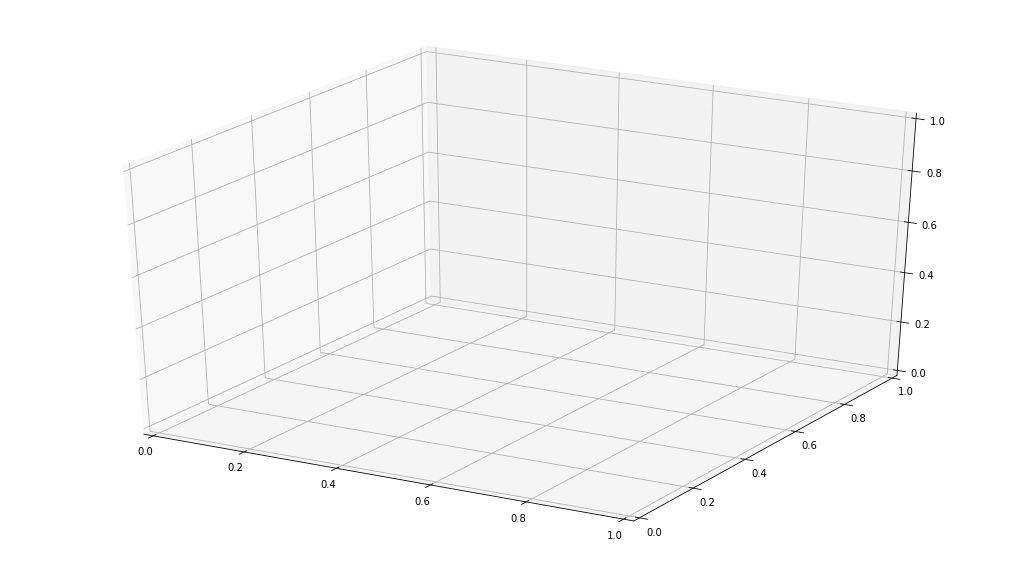

In [84]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
plt.rcParams['figure.figsize'] = [18, 10]

df = score_df.copy()
df.drop(columns=['MA_SHORT', 'MA_LONG', 'X_DAY_RETURN'], inplace=True)
df = df.loc[:, ['TURTLE_POS', 'ROLLMAX', 'RETURN']]
# df.set_index(keys='TURTLE_POS', inplace=True)
# df.sort_values(by='RETURN', ascending=False)
# df

# df = df.groupby(by='ROLLMAX').sum()
# df = df.groupby(by='ROLLMAX').mean()
# df = df.groupby(by='TURTLE_POS').mean()
# df.sort_values(by='RETURN', ascending=False)
# df

df[df['TURTLE_POS'] == 15]

# ax = df.plot(kind='line', x='ROLLMAX', y='RETURN', label='RETURN', linewidth=1, grid=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.bar(left='ROLLMAX', height='TURTLE_POS', zs='RETURN', zdir='TURTLE_POS', alpha=0.8)
# ax.bar(left=df['ROLLMAX'], height=df['TURTLE_POS'], zs=df['RETURN'], zdir=df['TURTLE_POS'], alpha=0.8)

# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# X
# Y
# x = df.columns
# x = np.arange(len(df.columns))
# x
# y = df.index
# y
# X,Y = np.meshgrid(x,y)
# Z = df
# Z
# ax.plot_surface(X, Y, Z)
# ax.bar(left=x, height=y, zs=Z, zdir=Z, alpha=0.8)